In [1]:
import os
import re
import warnings
import textwrap

from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from tqdm import tqdm_notebook
# tqdm_notebook().pandas()

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = 'bold'

In [3]:
def ingest_file(filename):
    
    df = (
        pd.read_csv(filename)
        .assign(date=lambda x: (x['date']
                                .replace(r'·', "", regex=True)
                                .apply(pd.to_datetime)))
    )

    return df

In [4]:
folder_path="../QR/dataset/"

df = (
    pd.concat((ingest_file(filename=folder_path+filename) for filename in tqdm(os.listdir(folder_path))),
              ignore_index=True)
    .sort_values('date', ascending=False)
    .drop_duplicates(ignore_index=True)
)

  0%|          | 0/101 [00:00<?, ?it/s]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65619 entries, 0 to 65618
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   link      65619 non-null  object             
 1   text      65619 non-null  object             
 2   date      65619 non-null  datetime64[ns, UTC]
 3   Likes     65619 non-null  int64              
 4   Comments  65619 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 2.5+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
df.head()

,link,text,date,Likes,Comments
0,https://twitter.com/olibatt/status/17364271384...,🙄 Once you announce something on the status of...,2023-12-17 16:44:00+00:00,1,1
1,https://twitter.com/intoxicat3/status/17363417...,@qrsupport I need help for the transit for my ...,2023-12-17 11:05:00+00:00,0,0
2,https://twitter.com/snigdhanandan/status/17363...,@qrsupport I wish I had read the IATA laws ear...,2023-12-17 09:26:00+00:00,0,1
3,https://twitter.com/YOUNGPGTECH/status/1736266...,"This is not good at all, cash should be accept...",2023-12-17 06:05:00+00:00,0,1
4,https://twitter.com/snigdhanandan/status/17362...,@qrsupport @qatarairways I had made a case the...,2023-12-17 05:15:00+00:00,2,4


In [8]:
for year in range(2017, 2024, 1):

    start_date = df.loc[df['date'].dt.year==year, 'date'].dt.date.min()
    end_date = df.loc[df['date'].dt.year==year, 'date'].dt.date.max()

    print(f"Year {year}: Start date: {start_date}, End Date:{end_date}")

Year 2017: Start date: 2017-08-09, End Date:2017-12-31
Year 2018: Start date: 2018-01-01, End Date:2018-12-31
Year 2019: Start date: 2019-01-01, End Date:2019-12-31
Year 2020: Start date: 2020-01-01, End Date:2020-12-31
Year 2021: Start date: 2021-01-01, End Date:2021-12-31
Year 2022: Start date: 2022-01-01, End Date:2022-12-31
Year 2023: Start date: 2023-01-01, End Date:2023-12-17


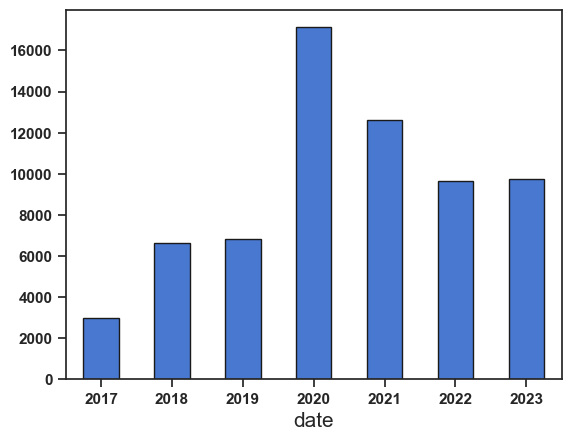

In [9]:
(
    df['date']
    .dt
    .year
    .value_counts()
    .sort_index()
    .plot(kind='bar', edgecolor='k', rot=0)
);

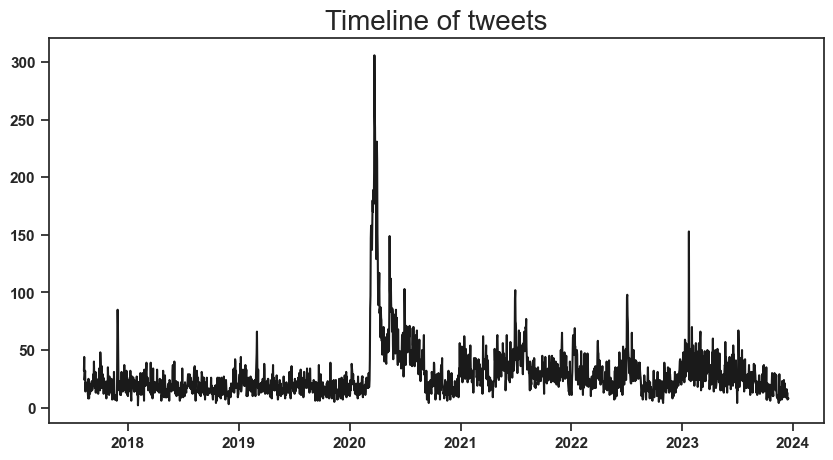

In [10]:
ax = (
    df.groupby(df['date'].dt.date).size()
    .plot(figsize=(10, 5), c='k', title='Timeline of tweets')
)

ax.set_xlabel("");

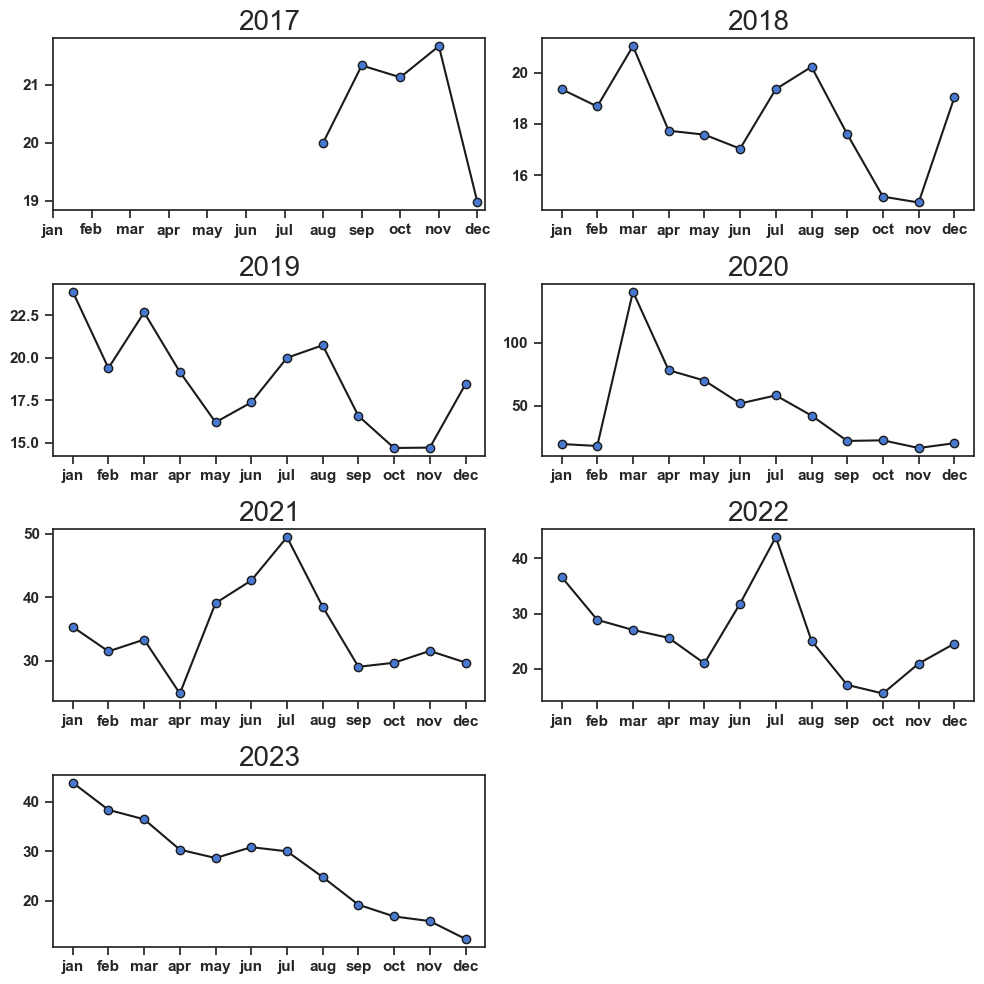

In [11]:
months=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 
        'oct', 'nov', 'dec']

fig, axes = plt.subplots(4, 2, figsize=(10, 10), tight_layout=True)

for year, ax in zip(range(2017, 2024, 1), axes.flatten()):

    ax = (
        df.loc[df['date'].dt.year==year]
        .assign(month=df['date'].dt.month)
        .groupby([df['date'].dt.date, 'month']).size()
        .groupby('month').mean()
        .plot(ax=ax, marker='o', mfc='b', c='k')
    )

    ax.set_title(year)
    ax.set_xlabel("")
    ax.set_xticks(ticks=range(1, 13, 1), labels=months)

axes.flatten()[-1].set_axis_off();

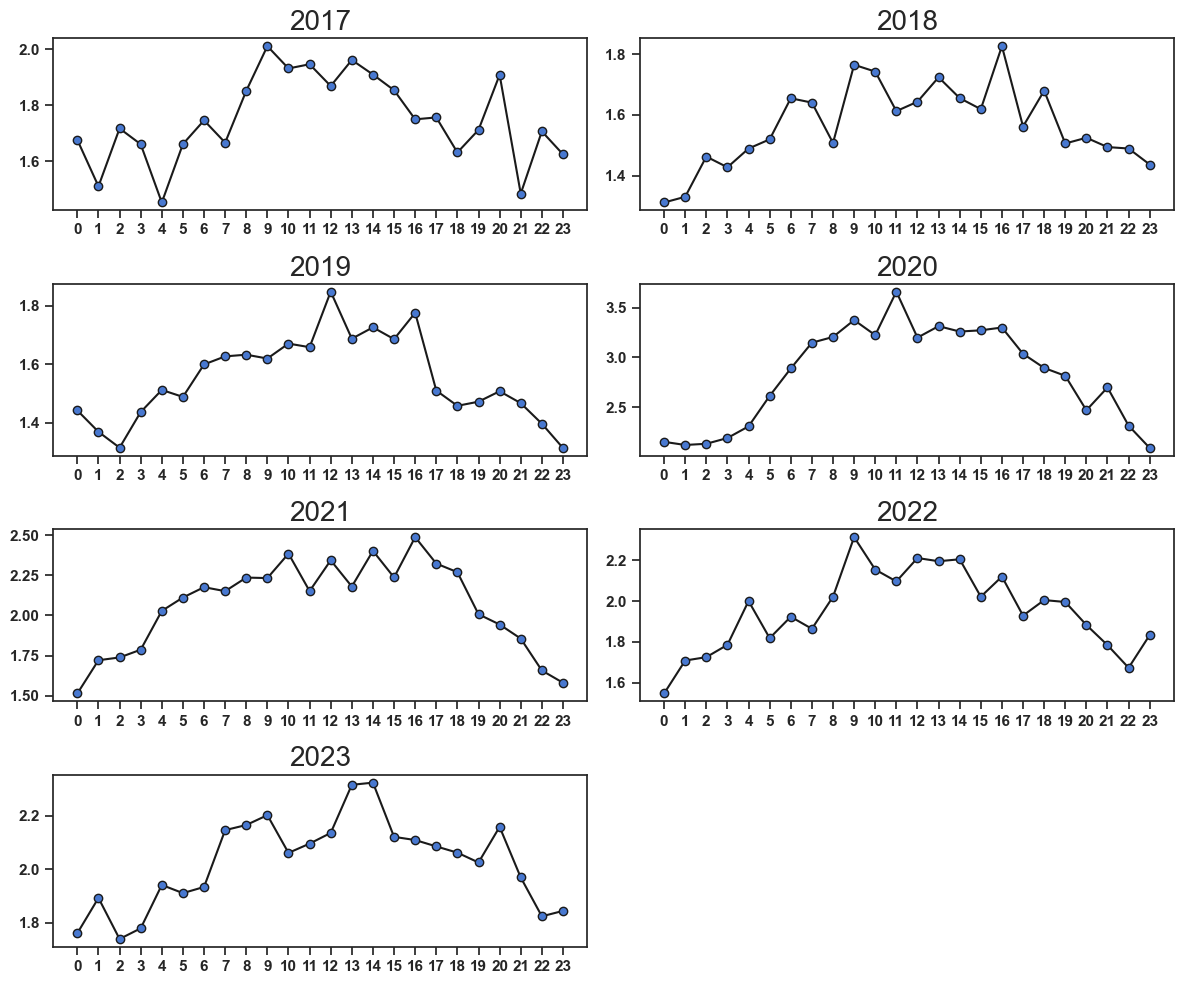

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(12, 10), tight_layout=True)

for year, ax in zip(range(2017, 2024, 1), axes.flatten()):

    ax = (
        df.loc[df['date'].dt.year==year]
        .assign(hour=df['date'].dt.hour)
        .groupby([df['date'].dt.date, 'hour']).size()
        .groupby('hour').mean()
        .plot(ax=ax, marker='o', mfc='b', c='k')
    )

    ax.set_title(year)
    ax.set_xlabel("")
    ax.set_xticks(range(24))

axes.flatten()[-1].set_axis_off();

In [13]:
def extract_pattern(text, pattern):    
    # Use re.findall to extract all matches in the text
    handles = re.findall(pattern, text)
    
    return handles

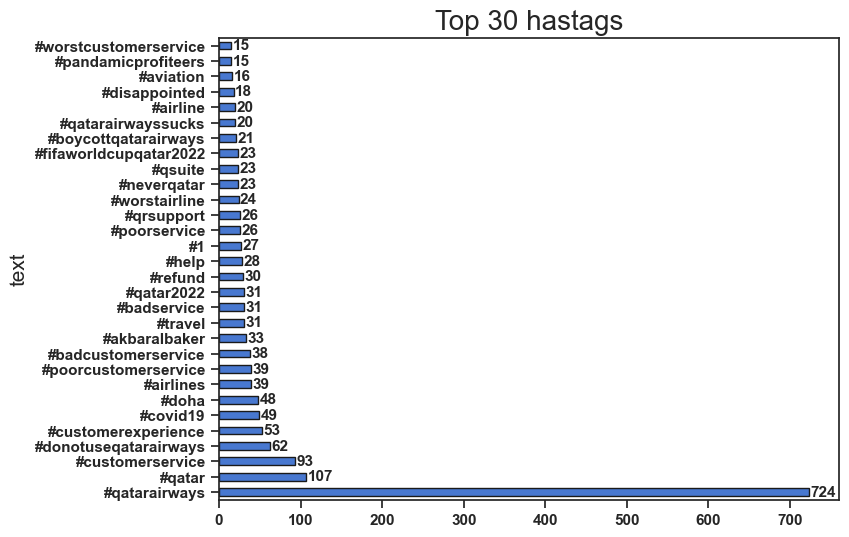

In [14]:
ax = (
    df['text'].str.lower()
    .apply(extract_pattern, pattern=r'(#\w+)')
    .explode()
    .dropna()
    .str.replace(r'\.$|,$|_', "", regex=True)
    .value_counts()
    .nlargest(30)
    .plot(kind='barh', edgecolor='k', figsize=(8, 6), title="Top 30 hastags")
)

for c in ax.containers:
    labels = [v for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="edge", fontweight = "bold", 
                 padding=1, fontsize=11)

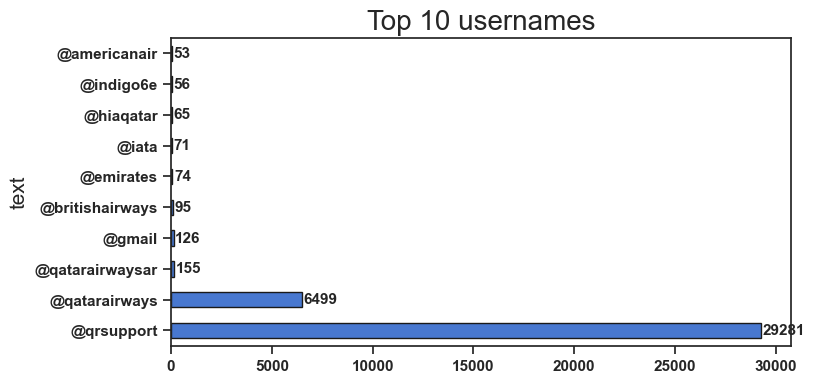

In [15]:
ax = (
    df['text'].str.lower()
    .apply(extract_pattern, pattern=r'(@\w+)')
    .explode()
    .dropna()
    .str.replace(r'\.$|,$|_', "", regex=True)
    .value_counts()
    .nlargest(10)
    .plot(kind='barh', edgecolor='k', figsize=(8, 4), title="Top 10 usernames")
)

for c in ax.containers:
    labels = [v for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="edge", fontweight = "bold", 
                 padding=1, fontsize=11)

In [16]:
# Create new column with all hashtags
df["hashtags"] = df['text'].apply(extract_pattern, pattern=r'(#\w+)')

In [17]:
df.loc[df['hashtags'].apply(lambda x: len(x)).ne(0)].tail(5)

,link,text,date,Likes,Comments,hashtags
65480,https://twitter.com/ching_snipz/status/8966925...,@qrsupport DO NOT CONTRIBUTE TO HUMAN RIGHTS A...,2017-08-13 11:19:00+00:00,0,0,[#FreeSaeed]
65481,https://twitter.com/ching_snipz/status/8966894...,@qrsupport PLEASE DO NOT CONTRIBUTE TO HUMAN R...,2017-08-13 11:06:00+00:00,7,0,[#FreeSaeed]
65482,https://twitter.com/TashaStaffieri/status/8966...,@qrsupport I'm returning from Bali with my new...,2017-08-13 10:35:00+00:00,0,1,[#justasking]
65581,https://twitter.com/Topsy89/status/89555068683...,@qrsupport any chance of being able to log int...,2017-08-10 07:41:00+00:00,0,1,"[#travelissues, #airlines, #BHX]"
65616,https://twitter.com/cpt_t88/status/89522710036...,"@qrsupport pls consider #Pune for new route, ...",2017-08-09 10:15:00+00:00,1,0,[#Pune]


# Sentiment Classification

In [18]:
# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax


MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)
model.save_pretrained(MODEL)

In [19]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Predict Sentiment
def predict_sentiment(text):

    encoded_inputs = tokenizer(text, 
                               padding=True, 
                               truncation=True, 
                               return_tensors="pt")
    
    outputs = model(**encoded_inputs)
    
    scores=softmax(outputs[0].detach().numpy(), axis=1)
    
    ranking = np.argsort(scores)[:, ::-1]
    
    sentiments = [{"label": config.id2label[rank[0]], "score":scores[i][rank[0]]} 
                  for i, rank in enumerate(ranking)]

    return sentiments

In [20]:
text = "Covid cases are increasing fast!"
predict_sentiment(text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'label': 'negative', 'score': 0.7235765}]

In [21]:
# Neutral
text=df.loc[0, "text"]
print(wrap_text(text))
print()
predict_sentiment(text)

🙄 Once you announce something on the status of (restarting) the CWL-DOH route, it
will quickly be picked up by UK aviation news sites and the local press. But either
way, you would first need to provide some information on the matter. Will the route
return by 31 Dec 2023?



[{'label': 'neutral', 'score': 0.7836185}]

In [22]:
# Negative
text=df.loc[25, "text"]
print(wrap_text(text))
print()
predict_sentiment(text)

@qrsupport @qatarairways I’m genuinely disappointed that my exist seat that I booked
for my 16hrs outward flight tomorrow to LAX was given to another passenger when I
only changed the date of my return flight. I’ve been a privilege member for 10+
years. Wasn’t offered a solution.



[{'label': 'negative', 'score': 0.87642694}]

In [23]:
# Positive
text=df.loc[65618, "text"]
print(wrap_text(text))
print()
predict_sentiment(text)

@qrsupport thanks for the amazing service! Welcome to Twitter and Keep up the good
work.



[{'label': 'positive', 'score': 0.9857216}]

In [30]:
# Define the batch size
batch_size = 64

# Load the tweets into memory
tweets = df.loc[:, 'text'].to_list() 

# Classify the tweets in batches
results = []
for i in tqdm(range(0, len(tweets), batch_size)):
    
    batch = tweets[i:i+batch_size]
    
    sentiments = predict_sentiment(batch)
    
    results.extend(sentiments)

  0%|          | 0/1026 [00:00<?, ?it/s]

In [31]:
df['sentiment']=results

In [35]:
# Positive
df.loc[df['sentiment'].apply(lambda x: x['label']=='positive'), ['text', 'sentiment']]

,text,sentiment
5,"Done, thanks","{'label': 'positive', 'score': 0.66862875}"
6,Thank you,"{'label': 'positive', 'score': 0.83540076}"
9,@qrsupport Good evening. I am flying from Lond...,"{'label': 'positive', 'score': 0.53198564}"
12,Thanks for the reply. Just DMed the info.,"{'label': 'positive', 'score': 0.6698953}"
21,Great I've sent you a DM thanks!,"{'label': 'positive', 'score': 0.97030526}"
...,...,...
65582,I hope inshallah soon QR will fly back there,"{'label': 'positive', 'score': 0.8066471}"
65603,@qrsupport What's the cost to change my flight...,"{'label': 'positive', 'score': 0.7694706}"
65612,My pleasure Qatar Airways,"{'label': 'positive', 'score': 0.9719187}"
65617,@qrsupport Welcome to the wonderful world of T...,"{'label': 'positive', 'score': 0.9725533}"


In [36]:
# Neutral
df.loc[df['sentiment'].apply(lambda x: x['label']=='neutral'), ['text', 'sentiment']]

,text,sentiment
0,🙄 Once you announce something on the status of...,"{'label': 'neutral', 'score': 0.7836185}"
1,@qrsupport I need help for the transit for my ...,"{'label': 'neutral', 'score': 0.7484599}"
4,@qrsupport @qatarairways I had made a case the...,"{'label': 'neutral', 'score': 0.60687053}"
11,When can I expect the refund?,"{'label': 'neutral', 'score': 0.88533795}"
13,@qrsupport how long does it normally take you ...,"{'label': 'neutral', 'score': 0.55621064}"
...,...,...
65606,"@qrsupport Hi, what do i need to do to get t...","{'label': 'neutral', 'score': 0.8471515}"
65607,@qrsupport Do I qualify for a hotel in Doha wi...,"{'label': 'neutral', 'score': 0.93680936}"
65614,Am I able to get a refund if I call and cancel...,"{'label': 'neutral', 'score': 0.7609061}"
65615,"@qrsupport Hi, im flying from London to Abu Dh...","{'label': 'neutral', 'score': 0.93251216}"


In [38]:
# negative
df.loc[df['sentiment'].apply(lambda x: x['label']=='negative'), ['text', 'sentiment']]

,text,sentiment
2,@qrsupport I wish I had read the IATA laws ear...,"{'label': 'negative', 'score': 0.9295316}"
3,"This is not good at all, cash should be accept...","{'label': 'negative', 'score': 0.9209826}"
7,@qrsupport Could you let senior management kno...,"{'label': 'negative', 'score': 0.8420935}"
8,You have been saying this for l months. We hav...,"{'label': 'negative', 'score': 0.7575256}"
10,@qrsupport @gotravelyourway #unbanjoshcahill A...,"{'label': 'negative', 'score': 0.5453505}"
...,...,...
65608,@QRsupport Supposedly a 24/7 dedicated help li...,"{'label': 'negative', 'score': 0.9152156}"
65609,@QRSupport USELESS!!! You lie. You leave lugga...,"{'label': 'negative', 'score': 0.9573959}"
65610,@qrsupport To add to your rampant lies about s...,"{'label': 'negative', 'score': 0.9513783}"
65611,@qrsupport Extremely upset that not only did y...,"{'label': 'negative', 'score': 0.93999535}"


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65619 entries, 0 to 65618
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   link       65619 non-null  object             
 1   text       65619 non-null  object             
 2   date       65619 non-null  datetime64[ns, UTC]
 3   Likes      65619 non-null  int64              
 4   Comments   65619 non-null  int64              
 5   hashtags   65619 non-null  object             
 6   sentiment  65619 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 3.5+ MB


In [41]:
df.to_csv("qatarairways_tweets_sentiments.csv", index=False)